Взять данные по [ссылке](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) и:

- Провести разведочный анализ данных
    - какие зависимости в данных?
    - [сбалансированы](https://www.kaggle.com/code/marcinrutecki/best-techniques-and-metrics-for-imbalanced-dataset) ли классы?
    - основные статистики признаков
- Разделить данные на train/test
    - разделить на обучающую и тестовую подвыборки
    - сравнить статистики подвыборок и генеральной выборки
- Обучить модели классификации
    - какие метрики точности?
    - какая модель лучше всего справилась?

**1.1 какие зависимости в данных?**

О наборе данных

Контекст

Важно, чтобы компании, выпускающие кредитные карты, могли распознавать мошеннические транзакции по кредитным картам, чтобы с клиентов не взималась плата за товары, которые они не покупали.

Содержание

Набор данных содержит транзакции, совершенные европейскими держателями карт по кредитным картам в сентябре 2013 года.
В этом наборе данных представлены транзакции, произошедшие за два дня, где у нас есть 492 мошенничества из 284 807 транзакций. Набор данных сильно **несбалансирован**, на положительный класс (мошенничества) приходится 0,172% всех транзакций.

Он содержит только числовые входные переменные, которые являются результатом преобразования PCA. К сожалению, из-за проблем конфиденциальности мы не можем предоставить исходные характеристики и дополнительную справочную информацию о данных. Характеристики V1, V2,… V28 являются основными компонентами, полученными с помощью PCA, единственные функции, которые не были преобразованы с помощью PCA, - это «Время» и «Количество». Функция «Время» содержит секунды, прошедшие между каждой транзакцией и первой транзакцией в наборе данных. Функция «Сумма» представляет собой сумму транзакции. Эту функцию можно использовать для обучения с учетом затрат в зависимости от примера. Функция «Класс» — это переменная ответа, которая принимает значение 1 в случае мошенничества и 0 в противном случае.

Учитывая коэффициент дисбаланса классов, мы рекомендуем измерять точность с помощью площади под кривой точности-отзыва (AUPRC). Точность матрицы неточностей не имеет значения для несбалансированной классификации.



In [109]:
# чтение данных из csv файла
from google.colab import drive
import numpy as np
import pandas as pd

drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/23_24_ML_SPbPU/creditcard.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [110]:
df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

Из постановки мы знаем, что из всего набора типов, только 2 непреобразованны: 'Time', 'Amount'. Второй признак преобразовывать нет смысла, так как его элементы типа float. Первый признак является временным, поэтому его надо или разделить на вектор размерности n, чтобы модели не давали количественный приоритет какому-то времени, или просто удалить этот признак (в дальнейшем я так и сделал).

In [111]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Проверим, как зависят признаки друг от друга с помощью матрицы корреляции


<Axes: >

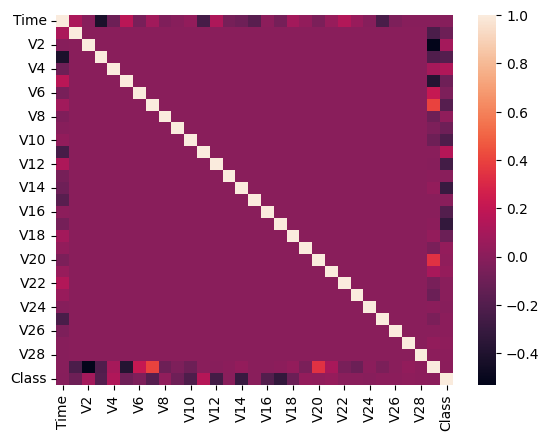

In [112]:
import seaborn as sns

sns.heatmap(df.corr())


Как можно заметить, признаки V1-V28 не коррелируют между собой. Есть небольшие корреляции между признакми 'Time', 'Amount' и 'Class'.

**1.2 сбалансированы ли классы?**

Проверим, действительно ли классы несбалансированный, как было в описании данных.


array([[<Axes: title={'center': 'Class'}>]], dtype=object)

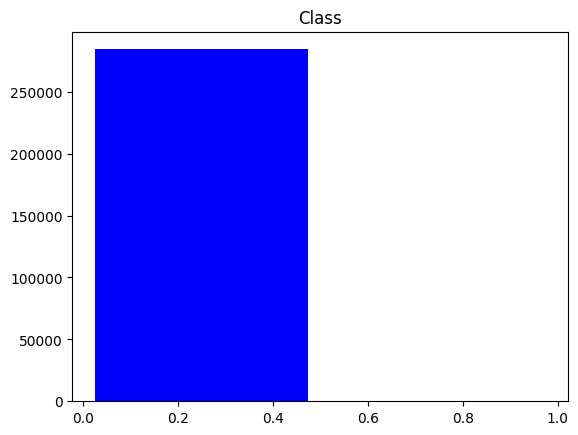

In [113]:
import matplotlib.pyplot as plt

df.hist (column='Class', bins= 2 , grid= False , rwidth= .9 , color='blue')

In [114]:
df["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

Данные, действительно, не сбалансированны.

**1.3 основные статистики признаков**

In [115]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000



**2.1 разделить на обучающую и тестовую подвыборки**




In [116]:
from sklearn.model_selection import train_test_split

random_state = 123

X_train, X_test, y_train, y_test = train_test_split(df.drop('Class', axis=1).drop('Time',axis=1).drop('Amount',axis=1), df[['Class']],
                                                     test_size=0.25, random_state=random_state)

**2.2 сравнить статистики подвыборок и генеральной выборки**



In [117]:
X_train.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
count,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,...,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000
mean,-0.002679,-0.004053,0.000547,-0.000763,0.002979,0.002415,0.001193,-0.000919,-0.000035,0.000063,...,0.001415,-0.000898,-0.000884,-0.000337,0.000186,0.000682,0.000670,-0.000819,0.000101,-0.000107
std,1.963674,1.655352,1.511092,1.416034,1.392772,1.340507,1.245646,1.201995,1.097726,1.082854,...,0.813979,0.773426,0.739661,0.726051,0.635004,0.605903,0.521366,0.481747,0.402869,0.331950
min,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.320155,-24.588262,...,-6.938297,-54.497720,-34.830382,-9.499423,-44.807735,-2.836627,-10.295397,-2.604551,-9.895244,-15.430084
25%,-0.922556,-0.599420,-0.889069,-0.847101,-0.690199,-0.767443,-0.554155,-0.208798,-0.643063,-0.535296,...,-0.454126,-0.211702,-0.228344,-0.542682,-0.161470,-0.354261,-0.316871,-0.327191,-0.071043,-0.053001
50%,0.016763,0.064480,0.178801,-0.021149,-0.052264,-0.273360,0.040659,0.022530,-0.051368,-0.092052,...,0.005664,-0.061488,-0.030014,0.005928,-0.010832,0.041077,0.018179,-0.053449,0.001256,0.011237
75%,1.315591,0.801944,1.025449,0.742190,0.615994,0.400860,0.570153,0.328697,0.597864,0.453182,...,0.459106,0.134110,0.185823,0.527378,0.147485,0.440432,0.351353,0.240060,0.091143,0.078104
max,2.454930,22.057729,4.226108,16.875344,34.801666,73.301626,120.589494,19.587773,10.370658,15.331742,...,5.591971,38.117209,27.202839,10.503090,22.528412,4.584549,6.070850,3.415636,31.612198,33.847808


In [118]:
X_test.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
count,71202.000000,71202.000000,71202.000000,71202.000000,71202.000000,71202.000000,71202.000000,71202.000000,71202.000000,71202.000000,...,71202.000000,71202.000000,71202.000000,71202.000000,71202.000000,71202.000000,71202.000000,71202.000000,71202.000000,71202.000000
mean,0.008036,0.012158,-0.001642,0.002289,-0.008936,-0.007244,-0.003579,0.002756,0.000105,-0.000189,...,-0.004246,0.002695,0.002651,0.001010,-0.000558,-0.002045,-0.002009,0.002457,-0.000302,0.000320
std,1.943678,1.639071,1.531648,1.415379,1.341940,1.307235,1.211077,1.171132,1.101354,1.106650,...,0.814217,0.763373,0.718890,0.724657,0.591706,0.604877,0.521012,0.483661,0.405918,0.324421
min,-36.802320,-63.344698,-32.965346,-5.416315,-42.147898,-19.996349,-41.506796,-50.688419,-13.434066,-24.403185,...,-7.213527,-22.838548,-22.757540,-10.933144,-36.666000,-2.814898,-8.696627,-2.534330,-22.565679,-11.710896
25%,-0.913244,-0.594926,-0.893900,-0.853596,-0.695862,-0.770917,-0.553536,-0.208126,-0.643236,-0.535903,...,-0.463101,-0.211774,-0.228542,-0.541240,-0.162853,-0.355785,-0.318009,-0.326327,-0.070258,-0.052860
50%,0.021405,0.068803,0.183604,-0.016333,-0.061614,-0.276547,0.038871,0.021741,-0.051807,-0.095189,...,-0.001698,-0.065324,-0.027933,0.009420,-0.012188,0.040685,0.012325,-0.048577,0.001572,0.011268
75%,1.315776,0.808725,1.031243,0.747018,0.601397,0.391496,0.571303,0.322753,0.594778,0.456423,...,0.458392,0.130266,0.188117,0.531852,0.147939,0.437034,0.348873,0.243066,0.090760,0.078861
max,2.446505,21.467203,9.382558,16.715537,28.762671,22.529298,36.677268,20.007208,15.594995,23.745136,...,4.851255,39.420904,27.202839,8.361985,19.228169,4.016342,7.519589,3.517346,11.135740,22.620072


Так как у нас только 1 целевой признак, то надо сравнить значение статистик именно по этому классу. Значение 'mean' у обоих выборок равно 88.597527 и 87.605901, а статистики 'std' 249.520375 и 251.911034. Отличия незначительные, а значит выборки аналогичные.



**3.1 какие метрики точности?**

Так как класс не сбалансированный, то обычными методами добиться хорошего результата не выйдет. Поэтому воспользуемся 'under-sampling' модели. В качестве метрики возьмем f1, так как имеено она позволит оценить одновременно и точность (Precision) и полноту (Recall).

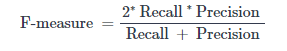

In [119]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.metrics import f1_score
import random
from sklearn.ensemble import RandomForestClassifier


p_dist = {'max_depth': [3,5,None],
          'n_estimators':[15],
          'criterion' : ['gini', 'entropy'],
          'bootstrap' : [True, False],
          'min_samples_leaf': [1,2,3,4]}


est = RandomForestClassifier(n_jobs = -1)
rdmsearch = RandomizedSearchCV(est, p_dist, cv=9, scoring=f1_score, n_jobs = -1)
rdmsearch.fit(X_train, y_train)


f1_score(y_test, rdmsearch.predict(X_test))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


0.7301587301587302

In [122]:
from sklearn.metrics import classification_report

print(classification_report(y_test, rdmsearch.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71055
           1       0.88      0.63      0.73       147

    accuracy                           1.00     71202
   macro avg       0.94      0.81      0.86     71202
weighted avg       1.00      1.00      1.00     71202



In [124]:
p_dist = {'max_depth':[1, 2, 3, 4, 5],
          'criterion':['gini', 'entropy'],
          'min_samples_split': [2, 3, 4, 5],
          'min_samples_leaf':[1, 2, 3, 4]}

clf = DecisionTreeClassifier(random_state=random_state)
dtsearch = RandomizedSearchCV(clf, p_dist, cv=9, scoring=f1_score, n_jobs=-1)
dtsearch.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


RandomizedSearchCV(cv=9, estimator=DecisionTreeClassifier(random_state=123),
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 3, 4, 5],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 3, 4, 5]},
                   scoring=<function f1_score at 0x7e575e87c310>)

In [125]:
f1_score(y_test, dtsearch.predict(X_test))

0.8247422680412372

In [126]:
print(classification_report(y_test, dtsearch.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71055
           1       0.83      0.82      0.82       147

    accuracy                           1.00     71202
   macro avg       0.92      0.91      0.91     71202
weighted avg       1.00      1.00      1.00     71202



Как можно заметить, обе модели оказались весьма эффективными. Рассмотрим модель, которая неочень хорошо работает с не балансными данными.

In [138]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf = LogisticRegression(class_weight='balanced')
clf.fit(X_train, y_train);
y_pred = clf.predict(X_test)

f1_score(y_test, y_pred)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.13157894736842105

In [139]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     71055
           1       0.07      0.92      0.13       147

    accuracy                           0.97     71202
   macro avg       0.54      0.95      0.56     71202
weighted avg       1.00      0.97      0.99     71202



**Вывод**

В данной работе использовались 3 различные модели (2 из которых были рассчитаны на не сбалансированные данные).

Лучше всего из них (по f1 метрике) оказался DecisionTreeClassifier со значением f1_score = 0.82

На втором месте RandomForestClassifier со значением f1_score = 0.73

И на последнем LogisticRegression  со значением f1_score = 0.13


**Работа над ошибками.**


1. Поработать с сэмплированием данных

Семплирование (сэмплинг, выборка) — выделение подмножества данных из всех собранных системой веб-аналитики данных и создание отчётов на их основе. Сэмплирование позволяет выбирать необходимое соотношение между скоростью и точностью расчёта.


Рассмотрим Оверсэмплинг со SMOTE:
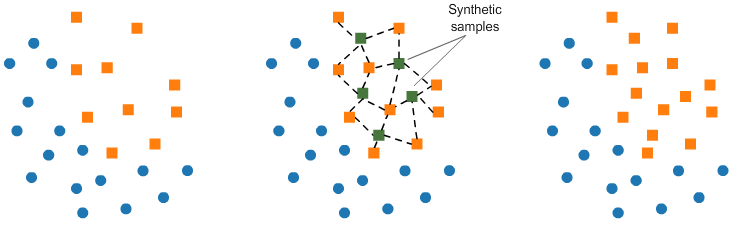

In [128]:
from imblearn.over_sampling import SMOTE


random_state = 123

X_train, X_test, y_train, y_test = train_test_split(df.drop('Class', axis=1).drop('Time',axis=1).drop('Amount',axis=1), df[['Class']],
                                                     test_size=0.25, random_state=random_state)
smote = SMOTE(random_state = 123)

X_SMOTE, y_SMOTE = smote.fit_resample(X_train, y_train)


Теперь класс несбалансирован в другую сторону. Попробуем методы, которые использовались.

In [136]:
clf = LogisticRegression(class_weight='balanced')
clf.fit(X_SMOTE, y_SMOTE);
y_pred = clf.predict(X_test)


print(classification_report(y_test, y_pred))


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       1.00      0.97      0.99     71055
           1       0.06      0.92      0.12       147

    accuracy                           0.97     71202
   macro avg       0.53      0.95      0.55     71202
weighted avg       1.00      0.97      0.98     71202



In [131]:
p_dist = {'max_depth':[1, 2, 3],
          'criterion':['gini', 'entropy'],
          'min_samples_split': [2, 3, 4, 5],
          'min_samples_leaf':[1, 2, 3, 4]}

clf = DecisionTreeClassifier(random_state=random_state)
#dtsearch = RandomizedSearchCV(clf, p_dist, cv=9, scoring=f1_score, n_jobs=-1)
dtsearch.fit(X_SMOTE, y_SMOTE)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


RandomizedSearchCV(cv=9, estimator=DecisionTreeClassifier(random_state=123),
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 3, 4, 5],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 3, 4, 5]},
                   scoring=<function f1_score at 0x7e575e87c310>)

In [132]:
f1_score(y_test, dtsearch.predict(X_test))

0.10260336906584992

In [133]:
print(classification_report(y_test, dtsearch.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     71055
           1       0.05      0.91      0.10       147

    accuracy                           0.97     71202
   macro avg       0.53      0.94      0.54     71202
weighted avg       1.00      0.97      0.98     71202



In [134]:
p_dist = {'max_depth': [3,5,None],
          'n_estimators':[15],
          'criterion' : ['gini', 'entropy'],
          'bootstrap' : [True, False],
          'min_samples_leaf': [1,2,3,4]}


est = RandomForestClassifier(n_jobs = -1)
#rdmsearch = RandomizedSearchCV(est, p_dist, cv=9, scoring=f1_score, n_jobs = -1)
rdmsearch.fit(X_SMOTE, y_SMOTE)


f1_score(y_test, rdmsearch.predict(X_test))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


0.8493150684931507

In [135]:
y_pred = rdmsearch.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71055
           1       0.86      0.84      0.85       147

    accuracy                           1.00     71202
   macro avg       0.93      0.92      0.92     71202
weighted avg       1.00      1.00      1.00     71202



Получились достаточно интересные результаты. Которые стоит отобразить в таблице
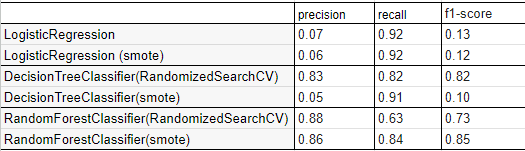

Модель LogisticRegression без SMOTE показывала результаты лучше, чем со SMOTE.

Модель DecisionTreeClassifier со  SMOTE показала очень плохие результаты отностельно той же модели но без SMOTE.

Модель RandomForestClassifier со SMOTE, наоборот, оказалась лучше, чем без SMOTE. Значительно выросла метрика recall, а значит модель чаще отлавливает мошенеческие операции.

Итог: Не смотря на то, что precision для RandomForestClassifier со SMOTE уменьшилась, модель показала наилучшие результаты (исходя из f1), за счет увеличения recall, который, как я думаю, является более весомым. Так как намного проще попросить подтвердить платеж, чем разбираться с последствиями мошенничества.